In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt
import stretchablecorr as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Available samples
0 - HS2_0p0
1 - gris_e_zoom8
2 - calibration
3 - calib_bruit_camera_x2
4 - calib_bruit_camera_x11.5
5 - PDMS_Amazon_18juin
6 - HS2
7 - calib_distortion_gris_x2


> Select an image directory: 6


HS2 selected
Load images from ./images/HS2...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


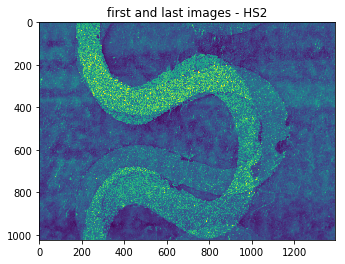

In [58]:
# ==================
#  Load image cube
# ==================
metadata = {}
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)
metadata['sample_name'] = sample_name

cube_last_first = (cube[0] + cube[-1])/2
plt.figure(); plt.title(f'first and last images - {sample_name}');
plt.imshow(cube_last_first, cmap='viridis');

grid size: 15x10
 i.e. 150 points


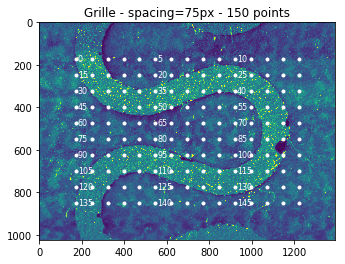

In [59]:
# ===============
#  Define a grid
# ===============
# margin > window_half_size
# margin > largest displacement

grid_spacing = 75  # px
grid_margin  = 150  # px

# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

metadata['grid_spacing'] = grid_spacing
metadata['grid_margin'] = grid_margin

# Graph
plt.figure();
plt.title(f'Grille - spacing={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3, show_pts_number=True,
                    window_half_size=None)

In [60]:
# =====================
#  Coarse displacement
# =====================

downscale = 3
params = {'window_half_size': 25,
          'method':'opti',
          'phase':True
         }

cube_reduced = [sc.pyramid_reduce(I, downscale=downscale) for I in cube]
points_reduced = points / downscale

print('actual window half size:', params['window_half_size']*downscale)
displ_coarse, err = sc.track_displ_img_to_img(cube_reduced, points_reduced, **params)
displ_coarse = displ_coarse * downscale

print('max displ:', np.nanmax(np.sqrt(np.sum(displ_coarse**2, axis=-1))), 'px')

# save metadata
meta_coarse = {'coarse_param':params, 'coarse_downscale':downscale}
metadata.update(meta_coarse)

actual window half size: 75
Compute image-to-image Lagrangian displacement field:
done                               
max displ: 44.63396624298927 px


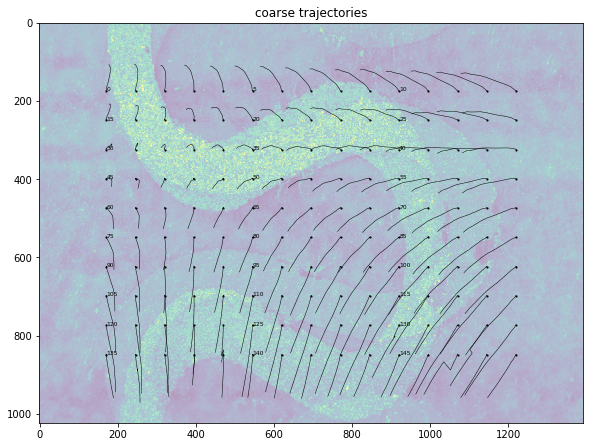

In [61]:
coarse_trajectories = sc.integrate_displacement(displ_coarse) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(coarse_trajectories, background=cube_last_first)
plt.title('coarse trajectories');

In [62]:
# ============
#  Refinement 
# ============

params = {'window_half_size': 20,
          'method':'opti',
          'phase':False}

displ, err = sc.track_displ_img_to_img(cube, points,
                                       offsets=displ_coarse,
                                       **params)

print('max displ:', np.nanmax(np.sqrt(np.sum(displ**2, axis=-1))), 'px')

Compute image-to-image Lagrangian displacement field:
done                               
max displ: 45.41965330583957 px


In [39]:
# save metadata & data
metadata.update(params)
sc.save_data((grid, displ, err, metadata),
             f'displ_Lagrangian_{len(points)}pts',
             sample_name)

data saved at ./output/HS2/displ_Lagrangian_140pts_164357.pck


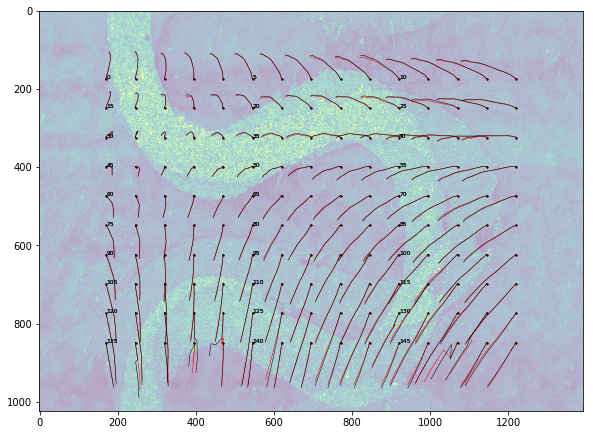

In [63]:
# Graph
trajectories = sc.integrate_displacement(displ) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(coarse_trajectories, background=cube_last_first, color='r')
sc.plot_trajectories(trajectories, background=None)

In [64]:
# ====================
#  two steps tracking 
# ====================

params = {'window_half_size': 20,
          'method':'opti',
          'phase':False}
tw_steps_displ, gaps, err1, err2 = sc.track_displ_2steps(cube, points,
                                                         offsets=displ_coarse,
                                                         **params)

Compute image-to-image Lagrangian displacement field:
done                               
Compute image-to-image Lagrangian displacement field:
done                               
Compute image-to-image Lagrangian displacement field:
done                               


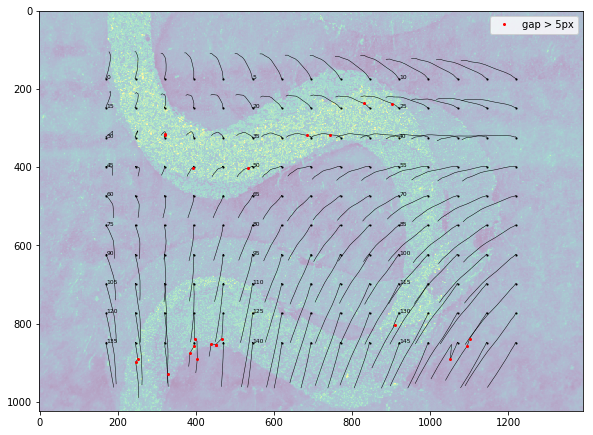

In [65]:
# graph
tw_steps_trajectories = sc.integrate_displacement(tw_steps_displ) + points

plt.figure(figsize=(10, 10*cube.shape[1]/cube.shape[2]));
sc.plot_trajectories(tw_steps_trajectories,
                     background=cube_last_first, gaps=gaps)

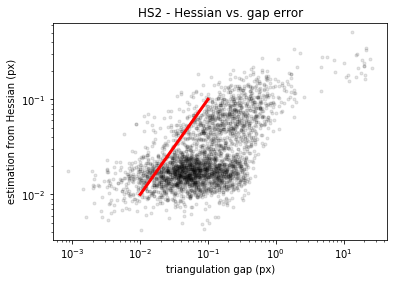

In [72]:
plt.title(f'{sample_name} - Hessian vs. gap error');
#plt.loglog(gaps.flatten(), np.sqrt(err1[1:, :, 1].flatten()), '.g', alpha=0.5);
#plt.loglog(gaps.flatten(), np.sqrt(err1[:, :, 1]), '.m', alpha=0.5);
plt.loglog(gaps.flatten(), np.sqrt(err2[:, :, 1].flatten()), '.k', alpha=0.1);
identity_line = [1e-2, 1e-1]
plt.loglog(identity_line, identity_line, '-r', linewidth=3)
plt.xlabel('triangulation gap (px)');
plt.ylabel('estimation from Hessian (px)');